In [2]:
from pathlib import Path

import jax
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

SYSTEMS = ("lorenz63", "rossler76", "hyperchen05")
DATASET_PATHS = {
    "lorenz63": {"train": "lorenz63_large.hdf5", "test": "lorenz63_large_test.hdf5"},
    "rossler76": {"train": "rossler76_train.hdf5", "test": "rossler76_test.hdf5"},
    "hyperchen05": {"train": "hyperchen05_train.hdf5", "test": "hyperchen05_test.hdf5"},
}
EXP_TYPES_ALL = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    "neighborhood",
    "normal",
    "proxy_tangent_evolution",
)
EXP_TYPES = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    # "proxy_tangent_evolution",
    "neighborhood",
)
COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        ("royalblue", "limegreen", "darkorange", "orangered", "saddlebrown", "purple"),
    )
)
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Vanilla",
            "Jacobian matching",
            "Tangent Evolution matching",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
            "Identity (ours)",
        ),
    )
)

datadir = Path("../../data")

In [3]:
system_dict = {}
for system in ("lorenz63", "rossler76", "hyperchen05"):
    lyapunov_dict = dict()
    for exp_type in ("vanilla", "tangent_evolution", "neighborhood"):
        lyapunov_dict[exp_type] = np.stack(
            [
                np.load(
                    f"../../results_analysis/{system}/lyapunovs/{exp_type}/downsample={2}_len=2_key={key}.npy"
                )
                for key in (0, 10, 20, 30, 40)
            ],
            axis=0,
        )
    system_dict[system] = lyapunov_dict
system_dict

{'lorenz63': {'vanilla': array([[ 9.00468135e-01, -1.05848051e-02, -1.08776883e+01],
         [ 9.01146623e-01, -1.25903290e-02, -1.23393762e+01],
         [ 9.00681636e-01, -1.07041389e-02, -1.09805672e+01],
         [ 9.00279937e-01, -9.42381377e-03, -1.08175565e+01],
         [ 9.00209864e-01, -1.00708501e-02, -1.01397549e+01]]),
  'tangent_evolution': array([[ 9.00503038e-01, -1.06713973e-02, -1.45558443e+01],
         [ 9.00197837e-01, -1.06476421e-02, -1.45555319e+01],
         [ 8.99868422e-01, -1.06327023e-02, -1.45533804e+01],
         [ 8.99886964e-01, -1.06241498e-02, -1.45570016e+01],
         [ 9.00421818e-01, -1.04680034e-02, -1.45547411e+01]]),
  'neighborhood': array([[ 9.00757282e-01, -1.09865238e-02, -1.46672811e+01],
         [ 8.99710644e-01, -1.14661972e-02, -1.47254531e+01],
         [ 9.00173588e-01, -1.10779835e-02, -1.45134142e+01],
         [ 9.00857857e-01, -1.12025600e-02, -1.45532618e+01],
         [ 8.98648563e-01, -1.10636342e-02, -1.43704787e+01]])},
 'r

In [4]:
lya_true_paths = {
    "lorenz63": "lorenz63_lyapunov_large_test.npz",
    "rossler76": "rossler76_lyapunov_test.npz",
    "hyperchen05": "hyperchen05_lyapunov_test.npz",
}

lya_true_dict = {
    k: np.mean(np.load(datadir / v)["lyas"][:, -1], axis=0)
    for k, v in lya_true_paths.items()
}

In [5]:
system_dict["lorenz63"]["vanilla"].shape

(5, 3)

Text(0, 0.5, '$\\lambda_{min}$')

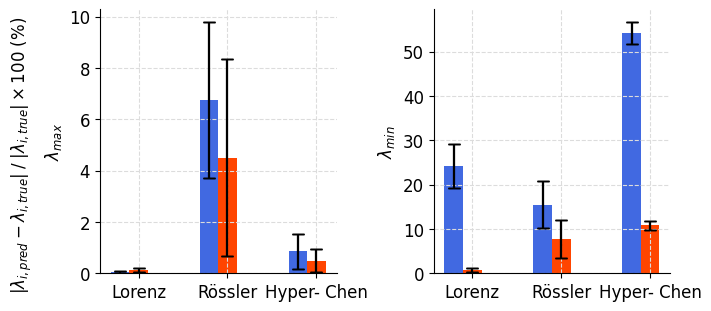

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
x = np.arange(3) * 1.2
width = 0.25
LABEL_DICT = {
    "vanilla": "MSE only",
    # "tangent_evolution": "$DF^T$ matching (ideal)",
    "neighborhood": "Neighborhood (ours)",
}

for s in system_dict.keys():
    for i, (exp_type, label) in enumerate(LABEL_DICT.items()):
        lya_err_mean = np.asarray(
            [
                np.mean(
                    np.abs(system_dict[s][exp_type][:, 0] - lya_true_dict[s][0])
                    / np.abs(lya_true_dict[s][0])
                )
                * 100
                for s in system_dict.keys()
            ]
        )
        lya_err_std = np.asarray(
            [
                np.std(
                    np.abs(system_dict[s][exp_type][:, 0] - lya_true_dict[s][0])
                    / np.abs(lya_true_dict[s][0])
                )
                * 100
                for s in system_dict.keys()
            ]
        )

        axes[0].bar(
            x + i * width,
            lya_err_mean,
            width,
            yerr=lya_err_std,
            label=label,
            color=COLOR_DICT[exp_type],
            capsize=4,
        )
for s in system_dict.keys():
    for i, (exp_type, label) in enumerate(LABEL_DICT.items()):
        lya_err_mean = np.asarray(
            [
                np.mean(
                    np.abs(system_dict[s][exp_type][:, -1] - lya_true_dict[s][-1])
                    / np.abs(lya_true_dict[s][-1])
                )
                * 100
                for s in system_dict.keys()
            ]
        )
        lya_err_std = np.asarray(
            [
                np.std(
                    np.abs(system_dict[s][exp_type][:, -1] - lya_true_dict[s][-1])
                    / np.abs(lya_true_dict[s][-1])
                )
                * 100
                for s in system_dict.keys()
            ]
        )

        axes[-1].bar(
            x + i * width,
            lya_err_mean,
            width,
            yerr=lya_err_std,
            label=label,
            color=COLOR_DICT[exp_type],
            capsize=4,
        )

axes[0].set_xticks(x + width, ["Lorenz", "Rössler", "Hyper- Chen"])
axes[1].set_xticks(x + width, ["Lorenz", "Rössler", "Hyper- Chen"])
axes[0].set_ylabel("Valid Prediction Time")
# ax.set_ylim((0.0, 5.0))
patches, labels = axes[0].get_legend_handles_labels()
# axes[1].legend(patches[:2], labels[:2], fontsize="medium")
fig.supylabel(
    r"$|\lambda_{i, pred}-\lambda_{i, true}|\; /\; |\lambda_{i, true}|\times 100$ (%)",
    fontsize="medium",
)
axes[0].set_ylabel(r"$\lambda_{max}$")
axes[1].set_ylabel(r"$\lambda_{min}$")

In [9]:
fig.savefig("../../figures/lyapunov_long_term.pdf", dpi=1200)

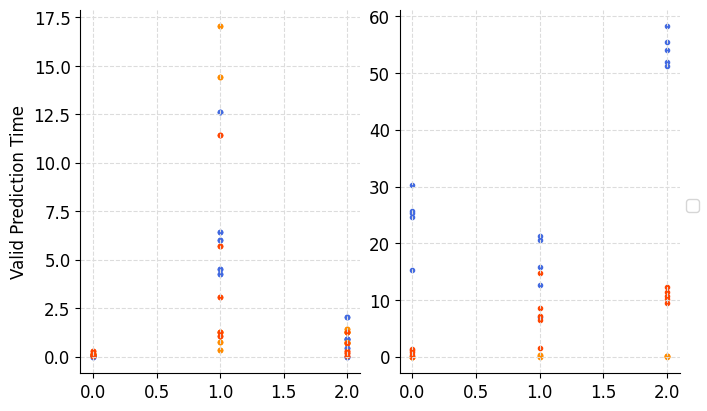

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
x = np.arange(3) * 1.2
width = 0.25
LABEL_DICT = {
    "vanilla": "MSE only",
    "tangent_evolution": "$DF^T$ matching (ideal)",
    "neighborhood": "Neighborhood (ours)",
}

for s in system_dict.keys():
    for i, (exp_type, label) in enumerate(LABEL_DICT.items()):
        lya_err = np.asarray(
            [
                np.abs(system_dict[s][exp_type][:, 0] - lya_true_dict[s][0])
                * 100
                / np.abs(lya_true_dict[s][0])
                for s in system_dict.keys()
            ]
        )
        for i in range(5):
            axes[0].scatter(np.arange(3), lya_err[:, i], color=COLOR_DICT[exp_type])

for i, (exp_type, label) in enumerate(LABEL_DICT.items()):
    lya_err = np.asarray(
        [
            np.abs(system_dict[s][exp_type][:, -1] - lya_true_dict[s][-1])
            * 100
            / np.abs(lya_true_dict[s][-1])
            for s in system_dict.keys()
        ]
    )
    for i in range(5):
        axes[1].scatter(np.arange(3), lya_err[:, i], color=COLOR_DICT[exp_type])
# axes[0].set_xticks(x + width, ["Lorenz", "Rössler", "Hyperchaotic Chen"])
axes[0].set_ylabel("Valid Prediction Time")
# axes[0].set_ylim((0.0, 1.0))
# ax.set_ylim((0.0, 5.0))
patches, labels = axes[0].get_legend_handles_labels()
fig.legend(patches[:3], labels[:3], loc="outside center right", fontsize="medium")